**Draw figures for algorithmic cooling:**

In [1]:
import argparse
import time
import random
import itertools
import numpy as np
import cvxpy as cp
import math
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from qutip import *
from qiskit import *
from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector, DensityMatrix, Operator, Pauli, partial_trace, state_fidelity, random_density_matrix
from qiskit.visualization import plot_histogram, plot_state_city, plot_bloch_multivector, plot_state_paulivec, plot_state_hinton, plot_state_qsphere
from qiskit.tools.monitor import job_monitor

from SDPforVQE import generate_PauliStrList, Hamiltonian_global, Hamiltonian_matrix, ground_state, lower_bound_with_SDP, N_meas_list_func
from SDPforVQE import get_SDP_dataset_min, get_SDP_dataset_max, process_SDP_dataset

/Users/wangzherui/anaconda3/envs/QuantumC/lib/python3.8/site-packages/qutip/__init__.py:66: UserWarning: The new version of Cython, (>= 3.0.0) is not supported.
  warnings.warn(


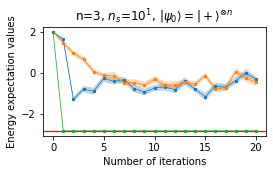

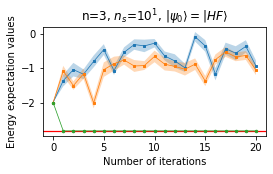

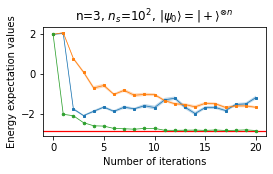

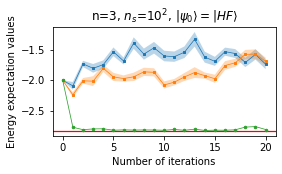

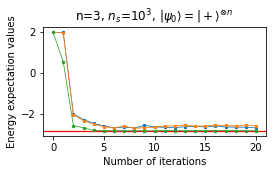

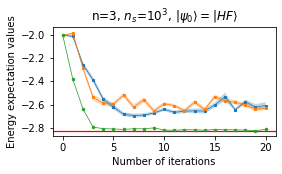

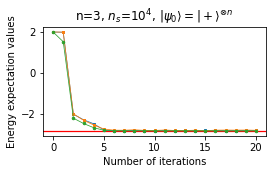

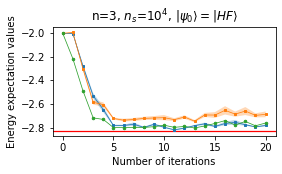

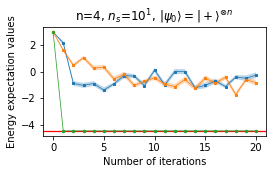

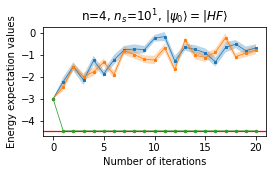

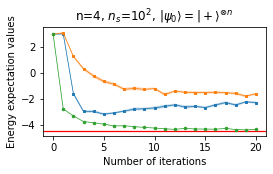

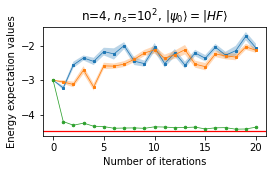

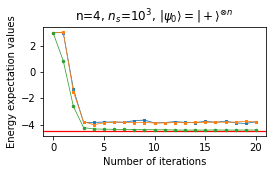

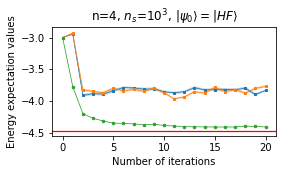

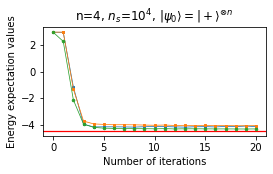

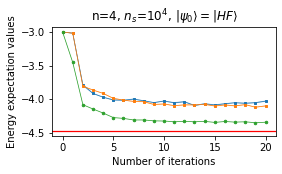

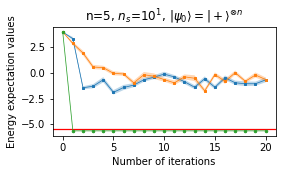

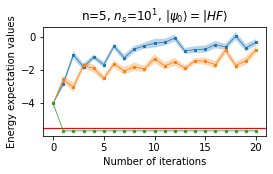

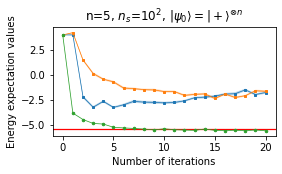

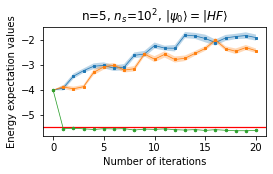

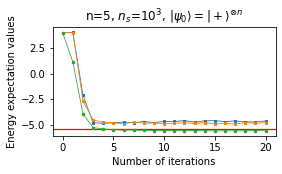

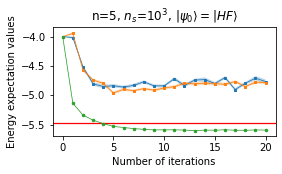

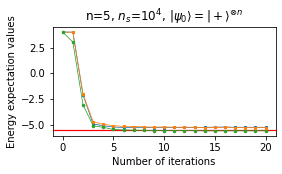

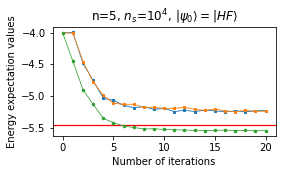

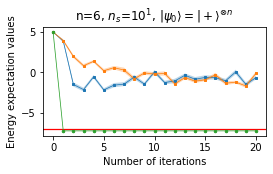

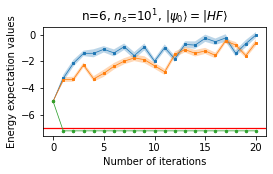

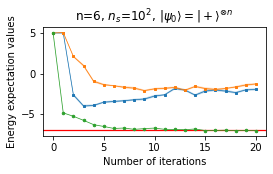

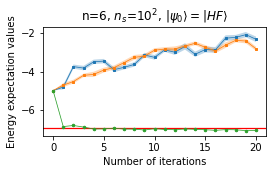

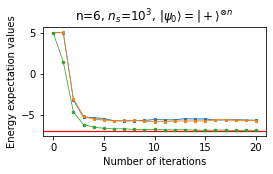

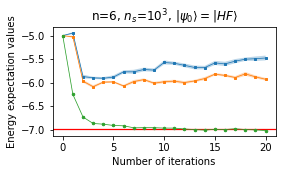

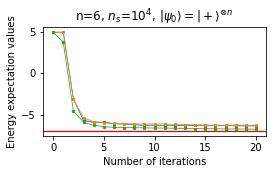

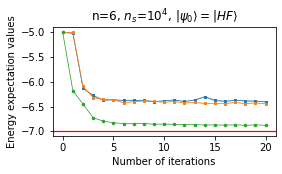

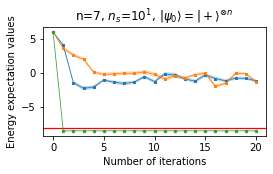

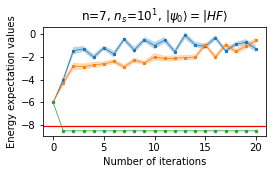

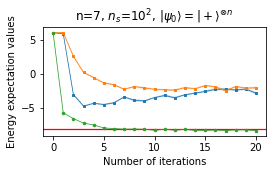

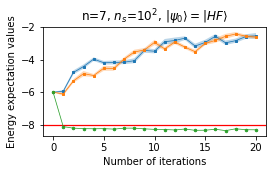

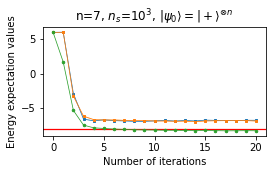

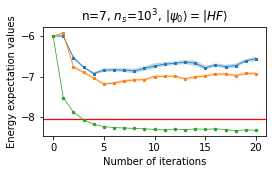

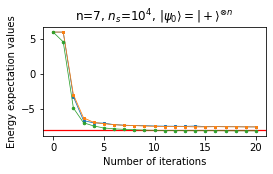

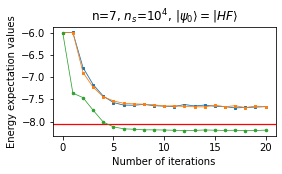

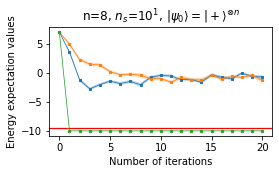

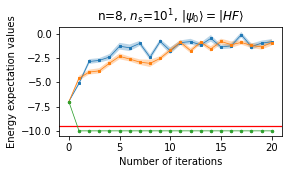

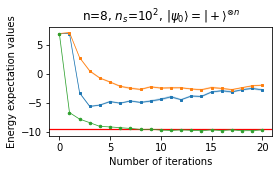

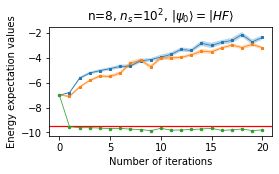

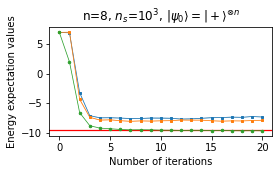

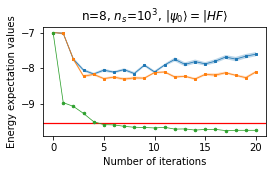

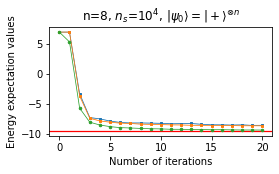

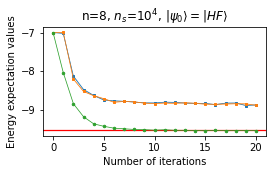

In [23]:
import pandas as pd
import os
import matplotlib.pyplot as plt

z = norm.ppf(1-0.01/2)/5
H_local_list = ['XX','YY'] # Pauli string representation of the local Hamiltonian of subsystems
model_type = 'open'
M = 2 # Number of qubits of subsystems
G = 3 # Number of qubits of partial global system (C1)

# Read the CSV file
df = pd.read_csv('combined_output.csv')

# Group the data by the combination of N, N_meas, and Initial_state
grouped = df.groupby(['N', 'N_meas', 'Initial_state'])

# Loop through each group and create the plots
for (N, N_meas, initial_state), group in grouped:
    
    if model_type == 'open':
        K = N-M+1 # Number of subsystems
    if model_type == 'closed':
        K = N
    P = 4**M-1 # Number of Pauli basis for each subsystem

    PauliStrList = generate_PauliStrList(N)[1:]
    PauliStrList_part = generate_PauliStrList(M)[1:]
    PauliStrList_Gbody = generate_PauliStrList(G)[1:]

    H_global_list = Hamiltonian_global(H_local_list, N, M, K, model_type) # Pauli string representation of the Hamiltonian of the whole system
    H_local_matrix = np.array( Hamiltonian_matrix(H_local_list, model_type) ) # Matrix representation of the local Hamiltonian of subsystems
    H_global_matrix = np.array( Hamiltonian_matrix(H_global_list, model_type) ) # Matrix representation of the Hamiltonian of the whole system
    ground_state_energy, ground_state_dm = ground_state(H_global_matrix)
    

    # Plot avg_expH, avg_expH_enhanced, and avg_expH_enhanced_SDPvalue against N_opt
    plt.figure(figsize=(4, 2))

    # Plot the theoretical ground state energy
    plt.axhline(y = ground_state_energy, color='r', linestyle='-', linewidth=1.25, label='GS energy')
    
    # Plot the case without SDP
    plt.plot(group['N_opt'].values, group['avg_expH'].values, linewidth=0.75, marker='s', markersize=2.5, label='Tomography')
    plt.fill_between(group['N_opt'], 
                    group['avg_expH']-z*group['std_expH'], 
                    group['avg_expH']+z*group['std_expH'], 
                    alpha=0.3)

    # Plot the case with SDP
    plt.plot(group['N_opt'], group['avg_expH_enhanced'], linewidth=0.75, marker='s', markersize=2.5, label='SDP-Enhanced')
    plt.plot(group['N_opt'], group['avg_expH_enhanced_SDPvalue'], linewidth=0.75, marker='o', markersize=2.5, label='SDP-Enhanced-min.')
    plt.fill_between(group['N_opt'], 
                    group['avg_expH_enhanced']-z*group['std_expH_enhanced'], 
                    group['avg_expH_enhanced']+z*group['std_expH_enhanced'],
                    alpha=0.3)
    plt.fill_between(group['N_opt'], 
                    group['avg_expH_enhanced_SDPvalue']-z*group['std_expH_enhanced_SDPvalue'], 
                    group['avg_expH_enhanced_SDPvalue']-z*group['std_expH_enhanced_SDPvalue'], 
                    alpha=0.3)
    
    # Add title, labels, and legend
    num_samples = r'$10^{{{}}}$'.format(int(np.log10(N_meas)))  # For N_meas in scientific notation
    titlename1 = f'n={N}, $n_s$={num_samples}'
    if initial_state == '++':
        titlename2 = r', $|\psi_0\rangle = |+\rangle^{\otimes n}$'
    if initial_state == 'HF':
        titlename2 = r', $|\psi_0\rangle = |HF\rangle$'
    titlename = titlename1 + titlename2
    plt.title(titlename)
    plt.xlabel('Number of iterations')
    plt.ylabel('Energy expectation values')
    #plt.legend()

    # Save the figure with a unique name in the 'plots' folder
    figurename = 'n' + str(N) + '_s' + str(int(N_meas)) + '_'+ initial_state +  '.pdf'
    save_path = os.path.join('ac_figure', figurename)
    #plt.savefig(save_path, bbox_inches='tight')
    
    # Show the plot
    plt.show()


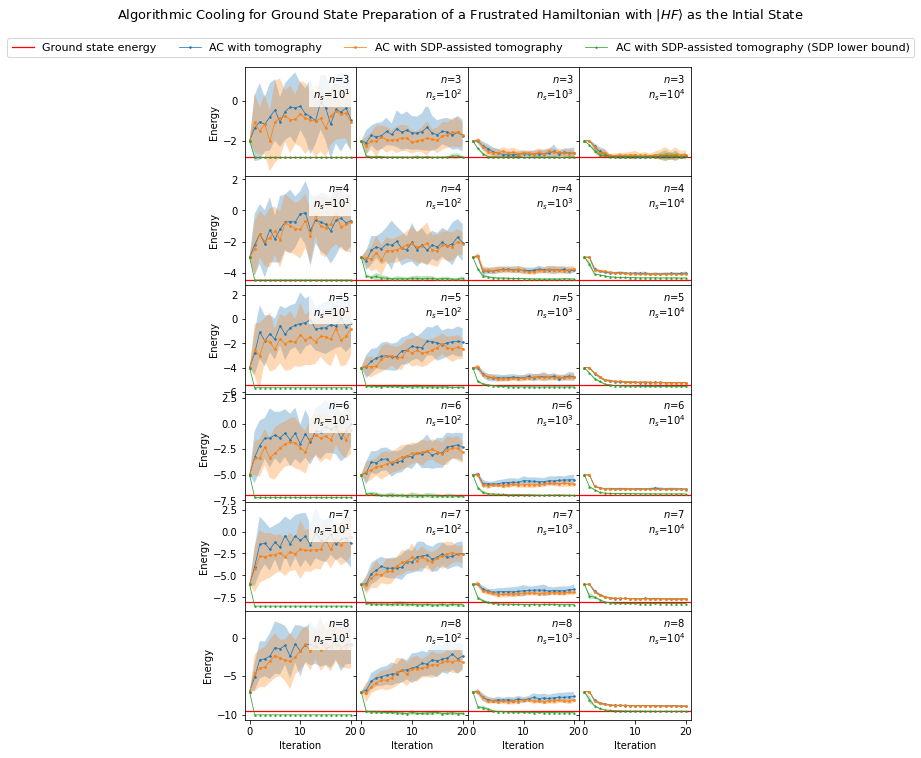

In [38]:
import pandas as pd
import os
import matplotlib.pyplot as plt

z = 5
H_local_list = ['XX','YY'] # Pauli string representation of the local Hamiltonian of subsystems
model_type = 'open'
initial_state = 'HF'
M = 2 # Number of qubits of subsystems
G = 3 # Number of qubits of partial global system (C1)

# Read the CSV file
df = pd.read_csv('combined_output.csv')

# Plot avg_expH, avg_expH_enhanced, and avg_expH_enhanced_SDPvalue against N_opt
fig = plt.figure(figsize=(8, 12))
gs = fig.add_gridspec(6, 4, hspace=0, wspace=0)
axs = gs.subplots(sharex=True, sharey=False)

for i, N in enumerate([3,4,5,6,7,8]):  # Columns: N
    row_min = float('inf') # Initialize variables to find the min and max y-limits for this row
    row_max = float('-inf') # Initialize variables to find the min and max y-limits for this row
    for j, N_meas in enumerate([10,100,1000,10000]):  # Rows: N_meas
        ax = axs[i,j]
        filtered_data = df[(df['N'] == N) & (df['N_meas'] == N_meas) & (df['Initial_state'] == initial_state)] # Filter data from dataframe

        # Calculated parameters for plotting
        if model_type == 'open':
            K = N-M+1 # Number of subsystems
        if model_type == 'closed':
            K = N
        P = 4**M-1 # Number of Pauli basis for each subsystem

        PauliStrList = generate_PauliStrList(N)[1:]
        PauliStrList_part = generate_PauliStrList(M)[1:]
        PauliStrList_Gbody = generate_PauliStrList(G)[1:]

        H_global_list = Hamiltonian_global(H_local_list, N, M, K, model_type) # Pauli string representation of the Hamiltonian of the whole system
        H_local_matrix = np.array( Hamiltonian_matrix(H_local_list, model_type) ) # Matrix representation of the local Hamiltonian of subsystems
        H_global_matrix = np.array( Hamiltonian_matrix(H_global_list, model_type) ) # Matrix representation of the Hamiltonian of the whole system
        ground_state_energy, ground_state_dm = ground_state(H_global_matrix)
        
        # Plot the theoretical ground state energy
        line_gs = ax.axhline(y = ground_state_energy, color='red', linestyle='-', linewidth=1.25, label='GS energy')
    
        # Plot the case without SDP
        curve_tomo, = ax.plot(filtered_data['N_opt'].values, filtered_data['avg_expH'].values, linewidth=0.75, marker='o', markersize=1.5, label='Tomography')
        ax.fill_between(filtered_data['N_opt'], 
                        filtered_data['avg_expH']-z*filtered_data['std_expH'], 
                        filtered_data['avg_expH']+z*filtered_data['std_expH'], 
                        alpha=0.3)

        # Plot the case with SDP
        curve_SDP, = ax.plot(filtered_data['N_opt'], filtered_data['avg_expH_enhanced'], linewidth=0.75, marker='s', markersize=1.5, label='SDP-Enhanced')
        ax.fill_between(filtered_data['N_opt'], 
                        filtered_data['avg_expH_enhanced']-z*filtered_data['std_expH_enhanced'], 
                        filtered_data['avg_expH_enhanced']+z*filtered_data['std_expH_enhanced'],
                        alpha=0.3)
        curve_SDP_min, = ax.plot(filtered_data['N_opt'], filtered_data['avg_expH_enhanced_SDPvalue'], linewidth=0.75, marker='^', markersize=1.5, label='SDP-Enhanced-min.')
        ax.fill_between(filtered_data['N_opt'], 
                        filtered_data['avg_expH_enhanced_SDPvalue']-z*filtered_data['std_expH_enhanced_SDPvalue'], 
                        filtered_data['avg_expH_enhanced_SDPvalue']+z*filtered_data['std_expH_enhanced_SDPvalue'], 
                        alpha=0.3)

        # Define the multiline text
        num_samples = r'$10^{{{}}}$'.format(int(np.log10(N_meas)))  # For N_meas in scientific notation
        line1 = f'$n$={N}'
        line2 = f'$n_s$={num_samples}'
        # Add multiline text in the upper right corner
        ax.text(0.95, 0.95, f"{line1}\n{line2}", transform=ax.transAxes, 
                fontsize=10, color="black", ha="right", va="top", 
                bbox=dict(facecolor="white", alpha=0.8, edgecolor="none"))

        # Collect the first line's handle and label for the legend
        if i == 0 & j == 0:  # Only collect for the first subplot
            handles = [line_gs, curve_tomo, curve_SDP, curve_SDP_min]
            labels = ["Ground state energy", 'AC with tomography', 'AC with SDP-assisted tomography', 'AC with SDP-assisted tomography (SDP lower bound)']
        
        # Get the current limits to find the range for the row
        current_min, current_max = ax.get_ylim()
        row_min = min(row_min, current_min)
        row_max = max(row_max, current_max)

    for j in range(4):
        axs[i,j].set_ylim(row_min, row_max)

# Add x and y axis and hide x ticks for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.set(xlabel='Iteration', ylabel='Energy')
for ax in axs.flat:
    ax.label_outer()

# Title and legend
if initial_state == '++':
    init_guess= r'$|+\rangle^{\otimes n}$'
if initial_state == 'HF':
    init_guess = r'$|HF\rangle$'

fig.suptitle('Algorithmic Cooling for Ground State Preparation of a Frustrated Hamiltonian with '+init_guess+' as the Intial State', fontsize=13, y=0.95)
fig.legend(handles, labels, loc='upper center', fontsize=11, ncol=len(handles), bbox_to_anchor=(0.5, 0.92))

# Save the figure with a unique name in the 'plots' folder
figurename = 'ac_HF.pdf'
save_path = os.path.join('ac_figure', figurename)
plt.savefig(save_path, bbox_inches='tight')

# Show the plot
plt.show()


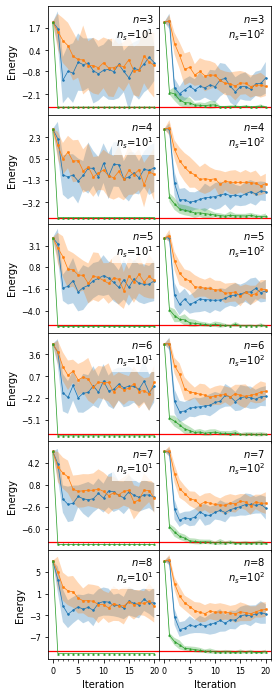

In [62]:
import pandas as pd
import os
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator, AutoMinorLocator

z = 5
H_local_list = ['XX','YY'] # Pauli string representation of the local Hamiltonian of subsystems
model_type = 'open'
initial_state = '++'
M = 2 # Number of qubits of subsystems
G = 3 # Number of qubits of partial global system (C1)

# Read the CSV file
df = pd.read_csv('combined_output.csv')

# Plot avg_expH, avg_expH_enhanced, and avg_expH_enhanced_SDPvalue against N_opt
fig = plt.figure(figsize=(4, 12))
gs = fig.add_gridspec(6, 2, hspace=0, wspace=0)
axs = gs.subplots(sharex=True, sharey=False)

for i, N in enumerate([3,4,5,6,7,8]):  # Columns: N
    row_min = float('inf') # Initialize variables to find the min and max y-limits for this row
    row_max = float('-inf') # Initialize variables to find the min and max y-limits for this row
    for j, N_meas in enumerate([10,100]):  # Rows: N_meas
        ax = axs[i,j]
        filtered_data = df[(df['N'] == N) & (df['N_meas'] == N_meas) & (df['Initial_state'] == initial_state)] # Filter data from dataframe
        # # Plot from the k-th point
        #filtered_data = filtered_data.iloc[3:]

        # Calculated parameters for plotting
        if model_type == 'open':
            K = N-M+1 # Number of subsystems
        if model_type == 'closed':
            K = N
        P = 4**M-1 # Number of Pauli basis for each subsystem

        PauliStrList = generate_PauliStrList(N)[1:]
        PauliStrList_part = generate_PauliStrList(M)[1:]
        PauliStrList_Gbody = generate_PauliStrList(G)[1:]

        H_global_list = Hamiltonian_global(H_local_list, N, M, K, model_type) # Pauli string representation of the Hamiltonian of the whole system
        H_local_matrix = np.array( Hamiltonian_matrix(H_local_list, model_type) ) # Matrix representation of the local Hamiltonian of subsystems
        H_global_matrix = np.array( Hamiltonian_matrix(H_global_list, model_type) ) # Matrix representation of the Hamiltonian of the whole system
        ground_state_energy, ground_state_dm = ground_state(H_global_matrix)
        
        # Plot the theoretical ground state energy
        line_gs = ax.axhline(y = ground_state_energy, color='red', linestyle='-', linewidth=1.25, label='GS energy')
    
        # Plot the case without SDP
        curve_tomo, = ax.plot(filtered_data['N_opt'].values, filtered_data['avg_expH'].values, linewidth=0.75, marker='o', markersize=1.5, label='Tomography')
        ax.fill_between(filtered_data['N_opt'], 
                        filtered_data['avg_expH']-z*filtered_data['std_expH'], 
                        filtered_data['avg_expH']+z*filtered_data['std_expH'], 
                        alpha=0.3)

        # Plot the case with SDP
        curve_SDP, = ax.plot(filtered_data['N_opt'], filtered_data['avg_expH_enhanced'], linewidth=0.75, marker='s', markersize=1.5, label='SDP-Enhanced')
        ax.fill_between(filtered_data['N_opt'], 
                        filtered_data['avg_expH_enhanced']-z*filtered_data['std_expH_enhanced'], 
                        filtered_data['avg_expH_enhanced']+z*filtered_data['std_expH_enhanced'],
                        alpha=0.3)
        curve_SDP_min, = ax.plot(filtered_data['N_opt'], filtered_data['avg_expH_enhanced_SDPvalue'], linewidth=0.75, marker='^', markersize=1.5, label='SDP-Enhanced-min.')
        ax.fill_between(filtered_data['N_opt'], 
                        filtered_data['avg_expH_enhanced_SDPvalue']-z*filtered_data['std_expH_enhanced_SDPvalue'], 
                        filtered_data['avg_expH_enhanced_SDPvalue']+z*filtered_data['std_expH_enhanced_SDPvalue'], 
                        alpha=0.3)

        # Define the multiline text
        num_samples = r'$10^{{{}}}$'.format(int(np.log10(N_meas)))  # For N_meas in scientific notation
        line1 = f'$n$={N}'
        line2 = f'$n_s$={num_samples}'
        # Add multiline text in the upper right corner
        ax.text(0.95, 0.95, f"{line1}\n{line2}", transform=ax.transAxes, 
                fontsize=10, color="black", ha="right", va="top", 
                bbox=dict(facecolor="white", alpha=0.8, edgecolor="none"))

        # Collect the first line's handle and label for the legend
        if i == 0 & j == 0:  # Only collect for the first subplot
            handles = [line_gs, curve_tomo, curve_SDP, curve_SDP_min]
            labels = ["Ground state energy", 'AC with tomography', 'AC with SDP-assisted tomography', 'AC with SDP-assisted tomography (SDP lower bound)']
        
        # Get the current limits to find the range for the row
        current_min, current_max = ax.get_ylim()
        row_min = min(row_min, current_min)
        row_max = max(row_max, current_max)

    for j in range(2):
        axs[i,j].set_ylim(row_min, row_max)

# Add x and y axis and hide x ticks for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.set(xlabel='Iteration', ylabel='Energy')
    #ax.set(xlabel='Iteration')
    ax.label_outer()
    ax.tick_params(axis='x', labelsize=8)
    ax.tick_params(axis='y', labelsize=8)
    ax.yaxis.set_major_locator(MaxNLocator(nbins=3))
    ax.xaxis.set_minor_locator(AutoMinorLocator(5))
    y_min, y_max = ax.get_ylim()
    ax.set_yticks([np.round(y_min+abs(y_min-y_max)/5, 1), np.round(y_min+2*abs(y_min-y_max)/5, 1), np.round(y_min+3*abs(y_min-y_max)/5, 1), np.round(y_max-abs(y_min-y_max)/5, 1)])

ax.set_xticks([0, 5, 10, 15, 20])  # Add ticks at specific locations

# Title and legend
if initial_state == '++':
    init_guess= r'$|+\rangle^{\otimes n}$'
if initial_state == 'HF':
    init_guess = r'$|HF\rangle$'

# Save the figure with a unique name in the 'plots' folder
figurename = 'ac_++_1e12.pdf'
save_path = os.path.join('ac_figure', figurename)
plt.savefig(save_path, bbox_inches='tight')

# Show the plot
plt.show()


In [18]:
from brokenaxes import brokenaxes

# Create a broken x-axis plot
bax = brokenaxes(xlims=((0, 3), (3.5, 10)), hspace=0.05, d=0.015)  # Adjust limits and spacing

# Plot the data
bax.plot(filtered_data['N_opt'], filtered_data['avg_expH'], label='Tomography', marker='o', markersize=2)
bax.plot(filtered_data['N_opt'], filtered_data['avg_expH_enhanced'], label='SDP-Enhanced', marker='s', markersize=2)

# Add labels and legend
bax.set_xlabel('Number of Measurements')
bax.set_ylabel('Energy Expectation')
bax.legend()

# Show the plot
plt.show()

ModuleNotFoundError: No module named 'brokenaxes'

In [ ]:
# Double log plots for large number of measurements

label_1 = "Ground State Energy (Theoretical)"
label_2 = "Ground State Energy (Relaxation Method)"
label_3 = "Exp. Avg. Upper Bound (99% CI)"
label_4 = "Exp. Avg. Lower Bound (99% CI)"
label_5 = f"SDP max. Sol. (Physical, $\\Delta={'{:.0e}'.format(threshold_max)}$)"
label_6 = f"SDP min. Sol. (Physical, $\\Delta={'{:.0e}'.format(threshold_min)}$)"
label_7 = f"SDP max. Sol. (Physical+Global, $\\Delta={'{:.0e}'.format(threshold_max)}$)"
label_8 = f"SDP min. Sol. (Physical+Global, $\\Delta={'{:.0e}'.format(threshold_min)}$)"

plt.axhline(y = 0, color='#E94560', linestyle='-', linewidth=1.25, label=label_1)
plt.axhline(y = lower_bound-ground_state_energy, color='#E94560', linestyle=':', linewidth=1.25, label=label_2)

def rgb_to_hex(rgb):
    return '#{:02x}{:02x}{:02x}'.format(int(rgb[0]*255), int(rgb[1]*255), int(rgb[2]*255))
color_palette = sns.color_palette('deep')

type_of_constraints = ['E_min', 'E_max', 'E_min_C01', 'E_min_C0']
color_code_list = [rgb_to_hex(color_palette[0]), rgb_to_hex(color_palette[0]),
                   rgb_to_hex(color_palette[1]), rgb_to_hex(color_palette[1]),
                   rgb_to_hex(color_palette[2]), rgb_to_hex(color_palette[2])]

# Draw the curves
d = 6
plt.plot(N_meas_list[-d:], E_mean_min['E_max'][-d:]-ground_state_energy, color=color_code_list[0], linewidth=0.75, marker='s', markersize=2.5, label=label_3)
plt.plot(N_meas_list[-d:], E_mean_min['E_min'][-d:]-ground_state_energy, color=color_code_list[0], linewidth=0.75, marker='^', markersize=2.5, label=label_4)
plt.plot(N_meas_list[-d:], E_mean_max['E_max_C0'][-d:]-ground_state_energy, color=color_code_list[2], linewidth=0.75, marker='s', markersize=2.5, label=label_5)
plt.plot(N_meas_list[-d:], E_mean_min['E_min_C0'][-d:]-ground_state_energy, color=color_code_list[2], linewidth=0.75, marker='^', markersize=2.5, label=label_6)
plt.plot(N_meas_list[-d:], E_mean_max['E_max_C01'][-d:]-ground_state_energy, color=color_code_list[4], linewidth=0.75, marker='s', markersize=2.5, label=label_7)
plt.plot(N_meas_list[-d:], E_mean_min['E_min_C01'][-d:]-ground_state_energy, color=color_code_list[4], linewidth=0.75, marker='^', markersize=2.5, label=label_8)

# Draw the shades
plt.fill_between(N_meas_list[-d:], 
                 E_mean_min['E_min'][-d:]-z*E_std_min['E_min'][-d:]-ground_state_energy, 
                 E_mean_min['E_min'][-d:]+z*E_std_min['E_min'][-d:]-ground_state_energy, facecolor=color_code_list[0], alpha=0.3)
plt.fill_between(N_meas_list[-d:], 
                 E_mean_min['E_max'][-d:]-z*E_std_min['E_max'][-d:]-ground_state_energy, 
                 E_mean_min['E_max'][-d:]+z*E_std_min['E_max'][-d:]-ground_state_energy, facecolor=color_code_list[0], alpha=0.3)
plt.fill_between(N_meas_list[-d:], 
                 E_mean_max['E_max_C0'][-d:]-z*E_std_max['E_max_C0'][-d:]-ground_state_energy, 
                 E_mean_max['E_max_C0'][-d:]+z*E_std_max['E_max_C0'][-d:]-ground_state_energy, facecolor=color_code_list[2], alpha=0.3)
plt.fill_between(N_meas_list[-d:], 
                 E_mean_min['E_min_C0'][-d:]-z*E_std_min['E_min_C0'][-d:]-ground_state_energy, 
                 E_mean_min['E_min_C0'][-d:]+z*E_std_min['E_min_C0'][-d:]-ground_state_energy, facecolor=color_code_list[2], alpha=0.3)
plt.fill_between(N_meas_list[-d:], 
                 E_mean_max['E_max_C01'][-d:]-z*E_std_max['E_max_C01'][-d:]-ground_state_energy, 
                 E_mean_max['E_max_C01'][-d:]+z*E_std_max['E_max_C01'][-d:]-ground_state_energy, facecolor=color_code_list[4], alpha=0.3)
plt.fill_between(N_meas_list[-d:], 
                 E_mean_min['E_min_C01'][-d:]-z*E_std_min['E_min_C01'][-d:]-ground_state_energy, 
                 E_mean_min['E_min_C01'][-d:]+z*E_std_min['E_min_C01'][-d:]-ground_state_energy, facecolor=color_code_list[4], alpha=0.3)

plt.xscale('log')
plt.yscale('symlog', linthresh = 0.1)
plt.ylabel('Difference')
plt.xlim(8386)
plt.grid(True, which="both", ls="-", linewidth=0.3)

figurename = model_type + '_data_N' + str(N) + '_zoom' + '.pdf'
figurepath = f'figures/{figurename}'
plt.savefig(figurepath, bbox_inches='tight')
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

x = np.arange(10)

fig = plt.figure()
ax = plt.subplot(111)

for i in range(5):
    line, = ax.plot(x, i * x, label='$y = %ix$'%i)

# Shrink current axis's height by 10% on the bottom
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 1,
                 box.width, box.height * 1])

# Put a legend below current axis
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),
          fancybox=True, shadow=True, ncol=5)

plt.show()

In [ ]:
fig = plt.figure()
ax = plt.subplot(111)

ax.axhline(y = ground_state_energy, color='#E94560', linestyle='-', linewidth=1.25, label=label_1)
ax.axhline(y = lower_bound, color='#E94560', linestyle=':', linewidth=1.25, label=label_2)

def rgb_to_hex(rgb):
    return '#{:02x}{:02x}{:02x}'.format(int(rgb[0]*255), int(rgb[1]*255), int(rgb[2]*255))
color_palette = sns.color_palette('deep')

type_of_constraints = ['E_min', 'E_max', 'E_min_C01', 'E_min_C0']
color_code_list = [rgb_to_hex(color_palette[0]), rgb_to_hex(color_palette[0]),
                   rgb_to_hex(color_palette[1]), rgb_to_hex(color_palette[1]),
                   rgb_to_hex(color_palette[2]), rgb_to_hex(color_palette[2])]

# Draw the curves
ax.plot(N_meas_list, E_mean_min['E_max'], color=color_code_list[0], linewidth=0.75, marker='s', markersize=2.5, label=label_3)
ax.plot(N_meas_list, E_mean_min['E_min'], color=color_code_list[0], linewidth=0.75, marker='^', markersize=2.5, label=label_4)

# Shrink current axis's height by 10% on the bottom
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 1,
                 box.width, box.height * 1])

# Put a legend below current axis
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),
          fancybox=True, shadow=False, ncol=5)

figurename = 'legend' + '.pdf'
figurepath = f'figures/{figurename}'
plt.savefig(figurepath, bbox_inches='tight')
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Sample data
x = N_meas_list[-5:]
y = E_mean_min['E_max'][-5:]-ground_state_energy

# Create a figure and axis
fig, ax = plt.subplots()

# Set the y-axis to log scale
ax.semilogy(N_meas_list[-5:], E_mean_min['E_max'][-5:]-ground_state_energy, color=color_code_list[0], linewidth=0.75, marker='s', markersize=2.5, label=label_3)
ax.semilogy(N_meas_list[-5:], E_mean_min['E_min'][-5:]-ground_state_energy, color=color_code_list[0], linewidth=0.75, marker='^', markersize=2.5, label=label_4)
ax.semilogy(N_meas_list[-5:], E_mean_max['E_max_C0'][-5:]-ground_state_energy, color=color_code_list[2], linewidth=0.75, marker='s', markersize=2.5, label=label_5)
ax.semilogy(N_meas_list[-5:], E_mean_min['E_min_C0'][-5:]-ground_state_energy, color=color_code_list[2], linewidth=0.75, marker='^', markersize=2.5, label=label_6)
ax.semilogy(N_meas_list[-5:], E_mean_max['E_max_C01'][-5:]-ground_state_energy, color=color_code_list[4], linewidth=0.75, marker='s', markersize=2.5, label=label_7)
ax.semilogy(N_meas_list[-5:], E_mean_min['E_min_C01'][-5:]-ground_state_energy, color=color_code_list[4], linewidth=0.75, marker='^', markersize=2.5, label=label_8)



# Customize the y-axis scale with a linear threshold
ax.set_yscale('symlog')
ax.set_ylim(1, -1)
ax.set_xscale('log')
ax.grid(True, which="both", ls="-")

# Add labels and a title
ax.set_xlabel('X-Axis')
ax.set_ylabel('Y-Axis (log scale)')
ax.set_title('Semilogy Plot with Custom Y-Axis Scale')

# Show the plot
plt.show()


In [ ]:
plt.figure(figsize=(8, 5))
label_1 = "Ground State Energy (Theoretical)"
label_2 = "Ground State Energy (Relaxation Method)"
label_3 = "Exp. Avg. Upper Bound (99% CI)"
label_4 = "Exp. Avg. Lower Bound (99% CI)"
label_5 = f"SDP min. Sol. (Physical+Global) ($\\Delta={threshold_max}$)"
label_6 = f"SDP min. Sol. (Physical+Global) ($\\Delta={threshold_min}$)"
label_7 = f"SDP min. Sol. (Physical) ($\\Delta={threshold_max}$)"
label_8 = f"SDP min. Sol. (Physical) ($\\Delta={threshold_min}$)"

plt.axhline(y = ground_state_energy, color='#E94560', linestyle='-', linewidth=1, label=label_1)
plt.axhline(y = lower_bound, color='#E94560', linestyle=':', linewidth=1, label=label_2)

def rgb_to_hex(rgb):
    return '#{:02x}{:02x}{:02x}'.format(int(rgb[0]*255), int(rgb[1]*255), int(rgb[2]*255))
color_palette = sns.color_palette('deep')

type_of_constraints = ['E_min', 'E_max', 'E_min_C01', 'E_min_C0']
color_code_list = [rgb_to_hex(color_palette[0]), rgb_to_hex(color_palette[0]),
                   rgb_to_hex(color_palette[1]), rgb_to_hex(color_palette[1]),
                   rgb_to_hex(color_palette[2]), rgb_to_hex(color_palette[2])]

# Draw the curves
c3, = plt.plot(N_meas_list, E_mean_min['E_max'], color=color_code_list[0], linewidth=0.75, marker='s', markersize=2.5, label=label_3)
c4, = plt.plot(N_meas_list, E_mean_min['E_min'], color=color_code_list[0], linewidth=0.75, marker='^', markersize=2.5, label=label_4)
c5, = plt.plot(N_meas_list, E_mean_max['E_min_C01'], color=color_code_list[4], linewidth=0.75, marker='s', markersize=2.5, label=label_5)
c6, = plt.plot(N_meas_list, E_mean_min['E_min_C01'], color=color_code_list[4], linewidth=0.75, marker='^', markersize=2.5, label=label_6)
#c7, = plt.plot(N_meas_list, E_mean_max['E_min_C0'], color=color_code_list[2], linewidth=0.75, marker='s', markersize=2.5, label=label_7)
#c8, = plt.plot(N_meas_list, E_mean_min['E_min_C0'], color=color_code_list[2], linewidth=0.75, marker='^', markersize=2.5, label=label_8)

# Draw the shades
plt.fill_between(N_meas_list, E_mean_min['E_min']-2.58*E_std_min['E_min'], E_mean_min['E_min']+2.58*E_std_min['E_min'], facecolor=color_code_list[0], alpha=0.3)
plt.fill_between(N_meas_list, E_mean_min['E_max']-2.58*E_std_min['E_max'], E_mean_min['E_max']+2.58*E_std_min['E_max'], facecolor=color_code_list[0], alpha=0.3)
plt.fill_between(N_meas_list, E_mean_max['E_min_C01']-2.58*E_std_max['E_min_C01'], E_mean_max['E_min_C01']+2.58*E_std_max['E_min_C01'], facecolor=color_code_list[4], alpha=0.3)
plt.fill_between(N_meas_list, E_mean_min['E_min_C01']-2.58*E_std_min['E_min_C01'], E_mean_min['E_min_C01']+2.58*E_std_min['E_min_C01'], facecolor=color_code_list[4], alpha=0.3)
#plt.fill_between(N_meas_list, E_mean_max['E_min_C0']-2.58*E_std_max['E_min_C0'], E_mean_max['E_min_C0']+2.58*E_std_max['E_min_C0'], facecolor=color_code_list[2], alpha=0.3)
#plt.fill_between(N_meas_list, E_mean_min['E_min_C0']-2.58*E_std_min['E_min_C0'], E_mean_min['E_min_C0']+2.58*E_std_min['E_min_C0'], facecolor=color_code_list[2], alpha=0.3)

# for key in type_of_constraints:
#     i = type_of_constraints.index(key)
#     plt.fill_between(N_meas_list, E_mean_min[key]-2.58*E_std_min[key], E_mean_min[key]+2.58*E_std_min[key], facecolor=color_code_list[i], alpha=0.3)
# plt.fill_between(N_meas_list, E_mean_max['E_max_C01']-2.58*E_std_max['E_max_C01'], E_mean_max['E_max_C01']+2.58*E_std_max['E_max_C01'], facecolor=color_code_list[2], alpha=0.3)

# Create two separate legend objects
legend1 = plt.legend([label_1, label_2, label_3, label_4], loc='lower right')

# Assuming you have threshold_upper and threshold_lower values defined
legend2 = plt.legend([c5, c6], [label_5, label_6], loc='upper right')

# Add both legend objects to the plot using add_artist()
plt.gca().add_artist(legend1)
plt.gca().add_artist(legend2)

plt.xscale('log')
plt.title('n = %s' % N)
plt.xlabel('Number of measurements')
plt.ylabel('Energy expectation value')
plt.grid(True, which="both", ls="-")

figurename = 'data_N' + str(N) + '.pdf'
figurepath = f'figures/{figurename}'
plt.savefig(figurepath)
plt.show()

In [ ]:
N = 3 # Number of qubits of the entire system
M = 2 # Number of qubits of subsystems
G = 3 # Number of qubits of partial global system (C1)
K = N-M+1 # Number of subsystems
P = 4**M-1 # Number of Pauli basis for each subsystem

PauliStrList = generate_PauliStrList(N)[1:]
PauliStrList_part = generate_PauliStrList(M)[1:]
PauliStrList_Gbody = generate_PauliStrList(G)[1:]

H_local_list = ['XX','YY']
H_global_list = Hamiltonian_global(H_local_list, N, M, K)
H_local = np.array( Hamiltonian_matrix(H_local_list) ) # The local Hamiltonian of subsystems
H_global = np.array( Hamiltonian_matrix(H_global_list) ) # The global Hamiltonian of interest

ground_state_energy, ground_state_dm = ground_state(H_global)
q_state = DensityMatrix(ground_state_dm)
lower_bound = lower_bound_with_SDP(H_local, N, M, K, P)

num_data_point = 4 # number of N_meas that we select to run
N_meas_list = N_meas_list_func(100, 1000, num_data_point) # A list of number of measurement performed in all basis
num_of_shot = 5 # Number of repeatation of the experiment

# Import the dataset of SDP results
threshold_upper = 0.01 
filename_upper = 'data_N' + str(N) + '_threshold' + str(threshold_upper)
path_upper = f'{filename_upper}.npy'
data_upper = np.load(path_upper, allow_pickle=True)
data_upper = data_upper.item()
E_mean_upper, E_std_upper = process_SDP_dataset(data_upper, num_of_shot, num_data_point)

threshold_lower = 0.01 
filename_lower = 'data_N' + str(N) + '_threshold' + str(threshold_lower)
path_lower = f'{filename_lower}.npy'
data_lower = np.load(path_lower, allow_pickle=True)
data_lower = data_lower.item()
E_mean_lower, E_std_lower = process_SDP_dataset(data_lower, num_of_shot, num_data_point)

In [ ]:
plt.figure(figsize=(7, 4))
#plt.figure(dpi=400)
plt.axhline(y = ground_state_energy, color='#E94560', linestyle='-', linewidth=1.5, label='Theoretical GS energy')
plt.axhline(y = lower_bound, color='#E94560', linestyle=':', linewidth=1, label=label_2)

type_of_constraints = ['E_min', 'E_max', 'E_min_C0', 'E_max_C0', 'E_min_C01', 'E_max_C01']
color_code_list = ['#4c72b0', '#4c72b0', '#dd8452', '#dd8452', '#55a868', '#55a868']

plt.plot(N_meas_list, E_mean_lower['E_min'], color='#4c72b0', linewidth=1, marker='s', markersize=2, label='Statistical GS energy (99%)')
plt.plot(N_meas_list, E_mean_lower['E_max'], color='#4c72b0', linewidth=1, marker='s', markersize=2)
plt.plot(N_meas_list, E_mean_lower['E_min_C0'], color='#dd8452', linewidth=1, marker='^', markersize=2, label='Physical compatibility')
plt.plot(N_meas_list, E_mean_lower['E_max_C0'], color='#dd8452', linewidth=1, marker='^', markersize=2)
#plt.plot(N_meas_list, E_mean_lower['E_min_C1'], color='k', linewidth=1, marker='^', markersize=2, label='Global compatibility')
#plt.plot(N_meas_list, E_mean_lower['E_max_C1'], color='k', linewidth=1, marker='^', markersize=2)
plt.plot(N_meas_list, E_mean_lower['E_min_C01'], color='#55a868', linewidth=1, marker='o', markersize=2, label='Three-body global verification')
plt.plot(N_meas_list, E_mean_lower['E_max_C01'], color='#55a868', linewidth=1, marker='o', markersize=2)



for key in type_of_constraints:
    i = type_of_constraints.index(key)
    plt.fill_between(N_meas_list, E_mean_lower[key]-2.58*E_std_lower[key], E_mean_lower[key]+2.58*E_std_lower[key], facecolor=color_code_list[i], alpha=0.3)

plt.xscale('log')
plt.title('N = %s' % N)
#plt.xlabel('Number of measurements')
plt.ylabel('Expectation value')
plt.legend()
plt.grid(True, which="both", ls="-")
plt.show()
